In [ ]:
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

conn = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=.;'  # Dấu chấm (.) là localhost
    'DATABASE=FLIGHTS_DDS;'
    'Trusted_Connection=yes;'
)

query = """
SELECT 
    f.ArrivalDelay,
    f.Distance,
    f.ScheduledDeparture, -- Cần xử lý cột này thành giờ
    d.DayOfWeekName AS DayOfWeek, -- Lấy từ bảng Fact hoặc join DimDate (trong code SQL bạn có DayOfWeekName ở DimDate)
    a.AirlineName,
    air.State as OriginState
FROM dbo.FactFlights f
JOIN dbo.DimAirlines a ON f.AirlineSK = a.AirlineSK
JOIN dbo.DimAirports air ON f.OriginAirportSK = air.AirportSK
JOIN dbo.DimDate d ON f.DateSK = d.DateSK
WHERE f.Cancelled = 0 -- Chỉ lấy chuyến bay thực tế, không lấy chuyến hủy
"""

df = pd.read_sql(query, conn)
print(df.head())

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18896\116241148.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   ArrivalDelay  Distance ScheduledDeparture DayOfWeek  \
0         -10.0    1217.0           05:19:00   Tuesday   
1          23.0     599.0           05:35:00   Tuesday   
2          30.0     733.0           05:52:00   Tuesday   
3          94.0     733.0           06:00:00   Tuesday   
4         -12.0     733.0           06:00:00   Tuesday   

                AirlineName OriginState  
0  American Airlines Inc.\r          MD  
1  American Airlines Inc.\r          IL  
2        Spirit Air Lines\r          IL  
3  American Airlines Inc.\r          IL  
4  American Airlines Inc.\r          NY  


# Classification (Dự báo chuyến bay trễ)
**Mục tiêu**: Xây dựng mô hình AI để trả lời câu hỏi: "Với hãng bay này, xuất phát giờ này, đi xa thế này, liệu có bị trễ (>15 phút) không?"
## 1.1 Tiền xử lý dữ liệu (Preprocessing)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

df['IsDelayed'] = np.where(df['ArrivalDelay'] > 15, 1, 0)

df['DepHour'] = pd.to_datetime(df['ScheduledDeparture'].astype(str), format='%H:%M:%S').dt.hour

features = ['Distance', 'DepHour', 'AirlineName', 'OriginState']
target = 'IsDelayed'

X = df[features].copy()
y = df[target]

le = LabelEncoder()
X['AirlineName'] = le.fit_transform(X['AirlineName'])
X['OriginState'] = le.fit_transform(X['OriginState'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.2 Huấn luyện và Đánh giá mô hình
Sử dụng thuật toán Random Forest (Rừng ngẫu nhiên) - thuật toán mạnh và phổ biến cho dạng dữ liệu bảng.

Đang huấn luyện mô hình...
Accuracy Score: 0.7815113719735877

Confusion Matrix:
 [[15850   123]
 [ 4344   128]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.99      0.88     15973
           1       0.51      0.03      0.05      4472

    accuracy                           0.78     20445
   macro avg       0.65      0.51      0.47     20445
weighted avg       0.72      0.78      0.70     20445



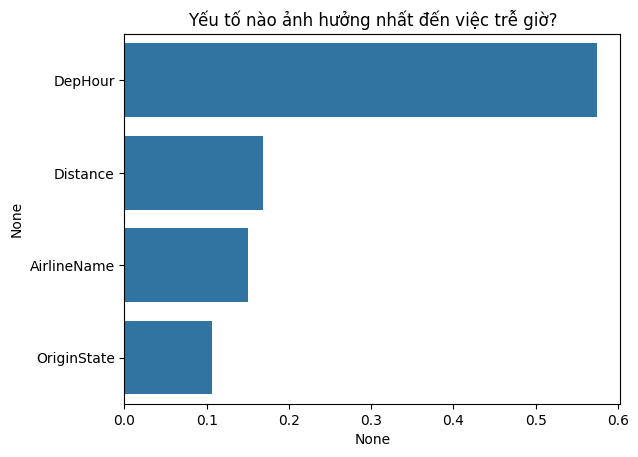

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

print("Đang huấn luyện mô hình...")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

feature_imp = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title("Yếu tố nào ảnh hưởng nhất đến việc trễ giờ?")
plt.show()

# Clustering (Phân cụm Sân bay)

**Mục tiêu:** Phân nhóm các sân bay dựa trên đặc tính hoạt động (Ví dụ: Nhóm sân bay "Bận rộn & Trễ nhiều", nhóm "Vắng vẻ & Đúng giờ"...). Đây là bài toán Unsupervised Learning (Học không giám sát).

## 2.1 Chuẩn bị dữ liệu tổng hợp (Aggregation)

In [ ]:
agg_query = """
SELECT 
    air.AirportNK,
    COUNT(f.FactFlightSK) as TotalFlights,
    AVG(f.DepartureDelay) as AvgDepDelay,
    AVG(f.Distance) as AvgDistance
FROM dbo.FactFlights f
JOIN dbo.DimAirports air ON f.OriginAirportSK = air.AirportSK
GROUP BY air.AirportNK
HAVING COUNT(f.FactFlightSK) > 5 -- GIẢM TỪ 100 XUỐNG 5 (Hoặc số nhỏ hơn tùy dữ liệu bạn)
"""

df_cluster = pd.read_sql(agg_query, conn)
print(f"Số lượng sân bay lấy được: {len(df_cluster)}") 

cluster_features = ['TotalFlights', 'AvgDepDelay', 'AvgDistance']
X_cluster = df_cluster[cluster_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_18896\4148203408.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_cluster = pd.read_sql(agg_query, conn)


Số lượng sân bay lấy được: 6


## 2.2 Tìm số cụm tối ưu (Elbow Method) và chạy K-Means

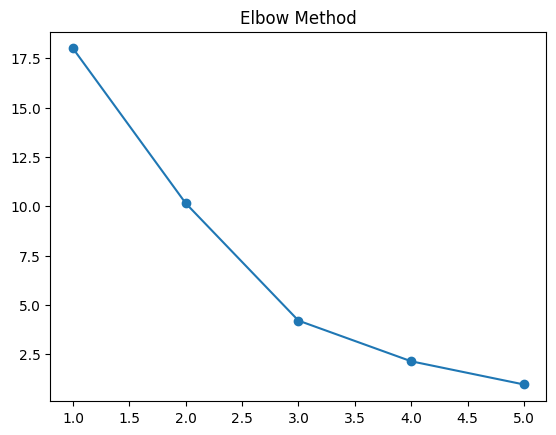

In [ ]:
inertia = []
import math
max_range = min(10, len(df_cluster)) 

for k in range(1, max_range):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_range), inertia, marker='o')
plt.title('Elbow Method')
plt.show()

## 2.3 Trực quan hóa kết quả (Scatter Plot)

Đang phân thành 3 cụm...


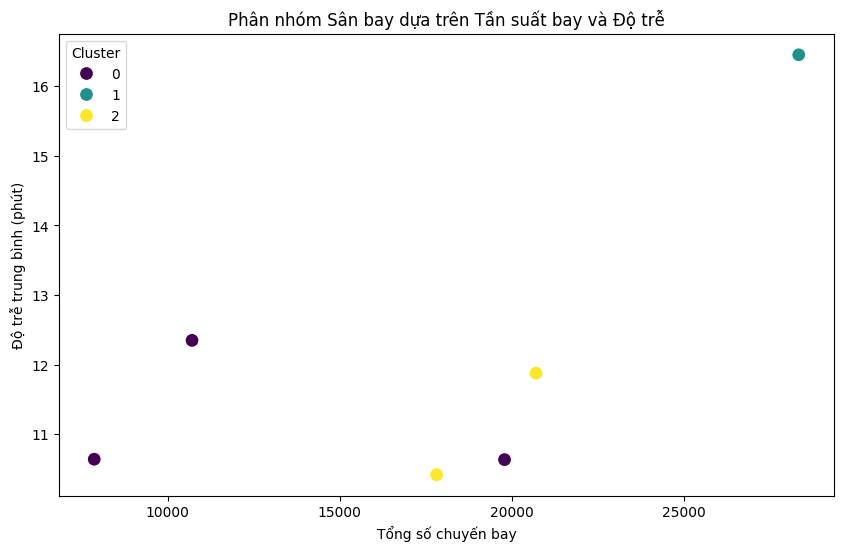

In [ ]:
import math
n_samples = len(df_cluster)
if n_samples > 3:
    k_optimal = 3
else:
    k_optimal = 2  

print(f"Đang phân thành {k_optimal} cụm...")

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)

df_cluster['Cluster'] = kmeans_final.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cluster, x='TotalFlights', y='AvgDepDelay', hue='Cluster', palette='viridis', s=100)
plt.title('Phân nhóm Sân bay dựa trên Tần suất bay và Độ trễ')
plt.xlabel('Tổng số chuyến bay')
plt.ylabel('Độ trễ trung bình (phút)')
plt.show()